In [1]:
# conda install scikit-learn==0.24.1

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder,PolynomialFeatures
from sklearn import preprocessing

from sklearn.decomposition import PCA

from sklearn.feature_selection import SequentialFeatureSelector,VarianceThreshold, RFECV,  SelectFromModel

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression #, Lasso, Ridge

from sklearn.model_selection import  cross_val_score, train_test_split ,cross_validate, KFold
from sklearn.pipeline import make_pipeline,  Pipeline
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

from sklearn.datasets import load_wine, make_classification, load_breast_cancer, load_diabetes

In [3]:
plt.style.use('seaborn-darkgrid')

## Exercise  1 - Scaling (3 points)

Perform standardization for wine dataset (`wine_data`) using only basic python, numpy and pandas (without using `StandardScaler` and sklearn at all). Implementation of function (or class) that can get dataset as input and return standardized dataset as output is preferrable, but not necessary.

Compare you results (output) with `StandardScaler`.

**NOTE:**

1) 1.5 points is for correct wine dataset standardization and another 1.5 points is for implementation of standardization function, that is working in more general case.

2) "General case" doesn't mean, that you need to handle some/all really "specific" cases (datasets with missing/categorial variables, very large dataset, etc). Let's assume that it should work with numeric datasets of reasonable shape: showing the output for one or two randomly generated 10x10 dataset and comparing the results with `StandardScaler` should be enough (or you can be more creative).


### Plan
1. Manual standartization with pd.DataFrame(data).apply(lambda x: ((x - np.mean(x))/np.std(x)))
2. Wrapper class of StandardScaler and overriding method fit_transform
3. Comparison will be with precision 1e-05 and command np.isclose. Will check on two random arrays and two datasets (WineData, HousingData)

### Manual standartization

In [4]:
## As mentioned manual will be realised as pd.DataFrame(data).apply(lambda x: ((x - np.mean(x))/np.std(x)))

### Wrapper class of StandardScaler and overriding method fit_transform

In [5]:
class StandardScalerWrap(StandardScaler):
    def __init__(self, copy=True, with_mean=True, with_std=True,
                 center_sparse=True):
        self.with_mean = with_mean
        self.with_std = with_std
        self.copy = copy
        self.center_sparse = center_sparse

    def fit_transform(self, X, y=None):
        ## realised only for y=None
        ## not realised checks that exist in original class
        scr = lambda r: (r - np.mean(X)) / np.std(X)
        scrs=np.array(scr(X))
        return scrs

In [6]:
scaler=StandardScaler()        
scalerWrap=StandardScalerWrap()

### Comparison

1. Array np.random.rand(10, 10) * 100

In [7]:
data=np.random.rand(10, 10) * 100
df_data=pd.DataFrame(data)
df_data_scaled=pd.DataFrame(scaler.fit_transform(df_data))
df_data_scaled_man=df_data.apply(lambda x: ((x - np.mean(x))/np.std(x)))
np.isclose(df_data_scaled, df_data_scaled_man, atol=1e-05).all()

True

In [8]:
df_data_scaled_wrap=scalerWrap.fit_transform(df_data)
np.isclose(df_data_scaled, df_data_scaled_wrap, atol=1e-05).all()

True

2. Array np.random.lognormal(3,10,[10,10])

In [9]:
data=np.random.lognormal(3,10,[10,10])
df_data=pd.DataFrame(data)
scaler=StandardScaler()
df_data_scaled=pd.DataFrame(scaler.fit_transform(df_data))
df_data_scaled_man=df_data.apply(lambda x: ((x - np.mean(x))/np.std(x)))
np.isclose(df_data_scaled, df_data_scaled_man, atol=1e-05).all()

True

In [10]:
df_data_scaled_wrap=scalerWrap.fit_transform(df_data)
np.isclose(df_data_scaled, df_data_scaled_wrap, atol=1e-05).all()

True

3. Wine data

In [11]:
wine_sklearn = load_wine(as_frame=True)
data=wine_sklearn['data']
df_data=pd.DataFrame(data)
scaler=StandardScaler()
df_data_scaled=pd.DataFrame(scaler.fit_transform(df_data))
df_data_scaled_man=df_data.apply(lambda x: ((x - np.mean(x))/np.std(x)))
np.isclose(df_data_scaled, df_data_scaled_man, atol=1e-05).all()

True

In [12]:
df_data_scaled_wrap=scalerWrap.fit_transform(df_data)
np.isclose(df_data_scaled, df_data_scaled_wrap, atol=1e-05).all()

True

4. Housing data

In [13]:
housing_data = pd.read_csv('Melbourne_housing_FULL.csv')
housing_data_mean = housing_data.fillna(housing_data.mean())
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
list_numerics_col=housing_data_mean.select_dtypes(include=numerics).columns.values
data=housing_data_mean[list_numerics_col]
df_data=pd.DataFrame(data)
scaler=StandardScaler()
df_data_scaled=pd.DataFrame(scaler.fit_transform(df_data))
df_data_scaled_man=df_data.apply(lambda x: ((x - np.mean(x))/np.std(x)))
np.isclose(df_data_scaled, df_data_scaled_man, atol=1e-05).all()

True

In [14]:
df_data_scaled_wrap=scalerWrap.fit_transform(df_data)
np.isclose(df_data_scaled, df_data_scaled_wrap, atol=1e-05).all()

True

### Plot samples

In [15]:
def plot_scatter(x, y, auto_scaled=True, title=None, clusters=None):
    plt.figure(figsize=(4, 4))
    plt.scatter(x, y)
    
    if not auto_scaled:
        plt.axis('square')
    
    plt.grid(True)
    plt.title(title)
    plt.show()
    
def return_X_y(data, target_column):
    return data.drop(target_column, axis=1), data[target_column]

## Exercise  2 - Visualization (4 points)

As noted earlier, standardization/normalization of data can be crucial for some distance-based ML methods.

Let’s generate some toy example of unnormalized data and visualize the importance of this process once more:

In [16]:
feature_0 = np.random.randn(1000) * 10   
feature_1 = np.concatenate([np.random.randn(500), np.random.randn(500) + 5])
data = np.column_stack([feature_0, feature_1])
data 

array([[-22.42415559,  -1.19434101],
       [ -0.54076639,  -1.45249566],
       [  3.1270728 ,   1.16926137],
       ...,
       [  4.81123785,   5.67651955],
       [ 21.51308586,   4.70095779],
       [ -0.99472856,   6.71406556]])

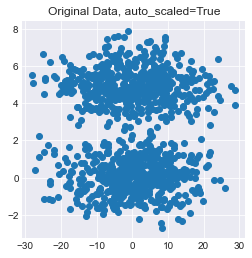

In [17]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=True, title='Original Data, auto_scaled=True')

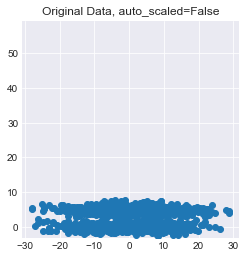

In [18]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False, title='Original Data, auto_scaled=False')

**NOTE:** on the plot above axes are scaled differently and we can clearly see two potential *classes/clusters*. In fact `matplotlib` performed `autoscaling` (which is basically can be considered as `MinMaxScaling` of original data) just for better visualization purposes.

Let's turn this feature off and visualize the original data on the plot with equally scaled axes:

This picture is clearly less interpretable, but much closer to "how distance-based algorithm see the original data": separability of data is hardly noticable only because the variation (std) of x-feature is much bigger in absolute numbers.

Perform `StandardScaling` and `MinMaxScaling` of original data; visualize results for each case (**use `plot_scatter` with `auto_scaled=False`**):

### MinMaxScaling (1 point)

In [19]:
min_max_scaler = MinMaxScaler()

In [20]:
data_minmax = min_max_scaler.fit_transform(data)

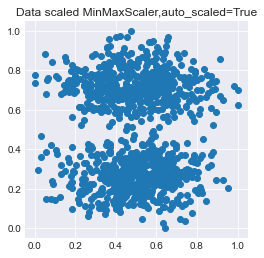

In [21]:
plot_scatter(data_minmax[:, 0], data_minmax[:, 1], auto_scaled=True, title='Data scaled MinMaxScaler,auto_scaled=True')

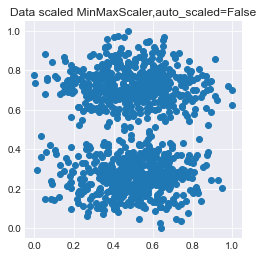

In [22]:
plot_scatter(data_minmax[:, 0], data_minmax[:, 1], auto_scaled=False, title='Data scaled MinMaxScaler,auto_scaled=False')

### StandardScaler (1 point)

In [23]:
scaler=StandardScaler()
data_stand = scaler.fit_transform(data)

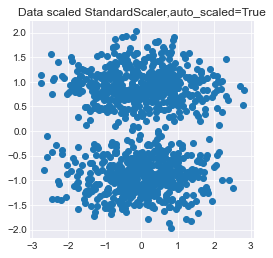

In [24]:
plot_scatter(data_stand[:, 0], data_stand[:, 1], auto_scaled=True, title='Data scaled StandardScaler,auto_scaled=True')

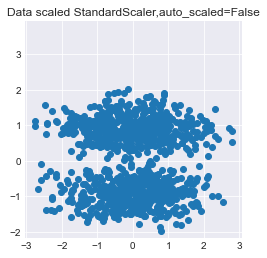

In [25]:
plot_scatter(data_stand[:, 0], data_stand[:, 1], auto_scaled=False, title='Data scaled StandardScaler,auto_scaled=False')

### (Bonus) K-means (2 points)

Illustrate the impact of scaling on basic distance-based clustering algorithm [K-means](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1) using `data` generated above.

**NOTE:** basically, you don't need understanding K-means algorithm here, you just need to:

1) run algorithm (with k=2, k - number of clusters/classes) on unscaled data    
2) run algorithm (with k=2) on scaled data    
3) plot results: highlight different clusters using different colors.

You can use this [question](https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering/89813) as a hint, but I recommend you to plot results using `plot_scatter` with `equal_scaled=True`: it might help you to intuitively understand the reasons of such scaling impact.

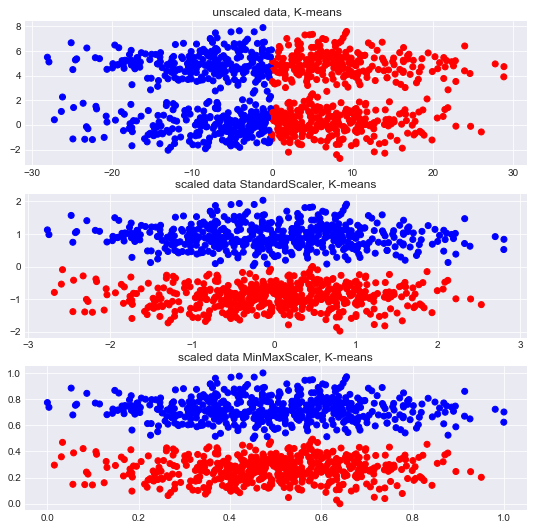

In [26]:
from sklearn.cluster import KMeans
%matplotlib inline
km=KMeans

fig, axes = plt.subplots(3, 1,figsize=(9, 9))
km = KMeans(2)
clusters = km.fit_predict(data)
axes[0].scatter(data[:, 0], data[:, 1], c=clusters, cmap='bwr')
axes[0].set_title(' unscaled data, K-means')

data_stand_km = scaler.fit_transform(data)
clusters = km.fit_predict(data_stand_km)
axes[1].scatter(data_stand_km[:, 0], data_stand_km[:, 1], c=clusters, cmap='bwr')
axes[1].set_title('scaled data StandardScaler, K-means')

data_minmax_km = min_max_scaler.fit_transform(data)
clusters = km.fit_predict(data_minmax_km)
axes[2].scatter(data_minmax_km[:, 0], data_minmax_km[:, 1], c=clusters, cmap='bwr')
axes[2].set_title('scaled data MinMaxScaler, K-means')
plt.show()

## Exercise  3 - Preprocessing Pipeline (3 points)

Train model (for example, `LogisticRegression(solver='liblinear', penalty='l1')` on raw `wine_train` data; 
then train same model after data scaling; 
then add feature selection (and train model again on scaled data).

Measure `accuracy` of all 3 approaches on `wine_val` dataset. Describe and explain results.

### Plan
1. Check if there are only numeric columns in `wine_train` dataset
2. Split data
3. Train model for `LogisticRegression(solver='liblinear', penalty='l1')` on raw data
4. Train the same model after data scaling
5. Adding feature selection and train model again on scaled data
6. Measuring `accuracy` for all 3 approaches
7. Outputs

In [27]:
wine_sklearn = load_wine(as_frame=True)
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

In [28]:
df=pd.DataFrame(wine_data)
df.describe()
y=pd.DataFrame(wine_labels)

Check if there are only numeric columns in wine_train dataset

In [29]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
list_all_col=df.columns.values
list_numerics_col=df.select_dtypes(include=numerics).columns.values
list_object_col=np.setxor1d(list_all_col,list_numerics_col)
list_object_col

array([], dtype=object)

### Split

In [30]:
# wine_train, wine_val, wine_labels_train, wine_labels_val 
X_train, X_test, y_train, y_test = train_test_split(wine_data, wine_labels, test_size=0.3, random_state=42)

### Train model (LogisticRegression(solver='liblinear', penalty='l1') on raw data

In [31]:
main_model = LogisticRegression(solver='liblinear', penalty='l1',max_iter=1200)

In [32]:
pipe_baseline = make_pipeline(None,main_model)

### Train the same model after data scaling

In [33]:
# scaler=MinMaxScaler()
scaler=StandardScaler()

In [34]:
pipe_scale = make_pipeline(scaler, main_model)

### Adding feature selection and train model again on scaled data

In [35]:
# selection_model = RandomForestClassifier(random_state=42)
# selector = SelectFromModel(selection_model).fit(X_train, y_train)
# print(X_train.columns[selector.get_support()])
# print(f'Original shape: {X_train.shape}')
# print(f'Shape after selection: {X_train.shape}')

In [36]:
feature_names = X_train.columns
selection_model = KNeighborsClassifier(n_neighbors=3)
selector = SequentialFeatureSelector(selection_model, n_features_to_select=10)
selector.fit(X_train, y_train)
print("Features selected by forward sequential selection: "
      f"{feature_names[selector.get_support()].tolist()}")

Features selected by forward sequential selection: ['alcohol', 'malic_acid', 'ash', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines']


In [37]:
pipe_selection = make_pipeline(scaler, selector, main_model) # fix to select only once

### Measuring `accuracy` for all 3 approaches

In [38]:
print('Result on original data: {:f}'.format(cross_val_score(pipe_baseline, X_train, y_train,scoring='accuracy', cv=5).mean()))

Result on original data: 0.903333


In [39]:
print('Result on original data: {:f}'.format(cross_val_score(pipe_baseline, X_test, y_test,scoring='accuracy', cv=5).mean()))

Result on original data: 0.945455


When maxiter is default than there is a  Warning "ConvergenceWarning: Liblinear failed to converge, increase the number of iterations" means that  problem is not well-conditioned, perhaps due to a poor scaling of the decision variables. https://stackoverflow.com/questions/52670012/convergencewarning-liblinear-failed-to-converge-increase-the-number-of-iterati

In [40]:
print('Result on scale data: {:f}'.format(cross_val_score(pipe_scale, X_train, y_train,scoring='accuracy', cv=5).mean()))

Result on scale data: 0.975667


In [41]:
print('Result on scale data: {:f}'.format(cross_val_score(pipe_scale, X_test, y_test,scoring='accuracy', cv=5).mean()))

Result on scale data: 0.981818


In [42]:
print('Result on select data: {:f}'.format(cross_val_score(pipe_selection, X_train, y_train,scoring='accuracy', cv=5).mean()))

Result on select data: 0.967667


In [43]:
print('Result on select data: {:f}'.format(cross_val_score(pipe_selection, X_test, y_test,scoring='accuracy', cv=5).mean()))

Result on select data: 0.981818


### Outputs

1. We used Logistic regression as target is categorical
2. As we checked during previous topic using regulasation with regression is significanly enhance result of model prediction
3. Using MinMaxScaler() instead of StandardScaler() gives almost the same result on scaled data, but brings 100% prediction on test scaled data, while train about 95%. It is strange and should be further checked for data lickage.
4. Using StandardScaler with RandomForestClassifier showed worse result that just scaling. But random forest regressor have a few hyperparameters that can be tuned to improve overall accuracy. I expect that result could be better after tuning.
5. Using StandardScaler with KNeighborsClassifier showed worse result with n_features_to_select=2 and better with higher number of features. As with random forest we need to tune  hyperparameters to improve overall accuracy.